# Análise e Exploração MovieLens

Utilizaremos dados do site oficial do GroupLens para pegarmos os filmes e seus rankings para analisar os melhores filmes e recomedar novos filmes para um usuario.

Fonte de dados: https://grouplens.org/datasets/movielens/latest/

Pegamos a versão small dos dados para fazermos as analises e recomendações.

In [28]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357271 sha256=65ef6e56ca02e7aaaee7eba20e3c3ff6c8c662b19d1f0ebbef18049ffb545a94
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


In [2]:
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

print("Movies:\n", df_movies.head(), "\n")
print("Ratings:\n", df_ratings.head(), "\n")
print("Tags:\n", df_tags.head(), "\n")
print("Links:\n", df_links.head(), "\n")

Movies:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Ratings:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

Tags:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2  

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


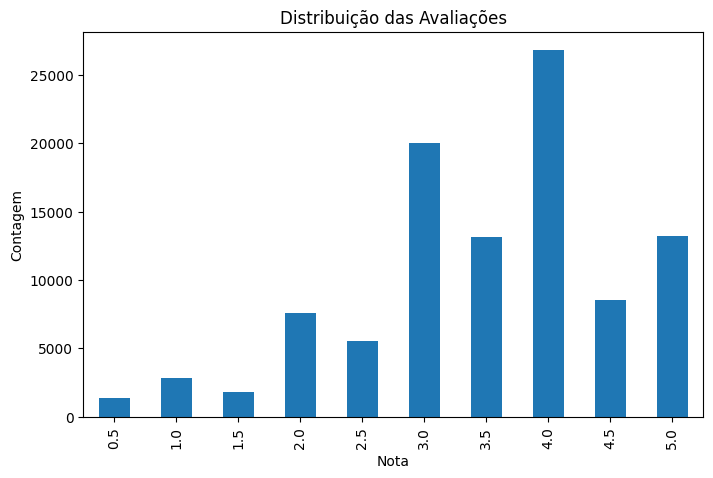

In [6]:
df_ratings['rating'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5))
plt.title("Distribuição das Avaliações")
plt.xlabel("Nota")
plt.ylabel("Contagem")
plt.show()

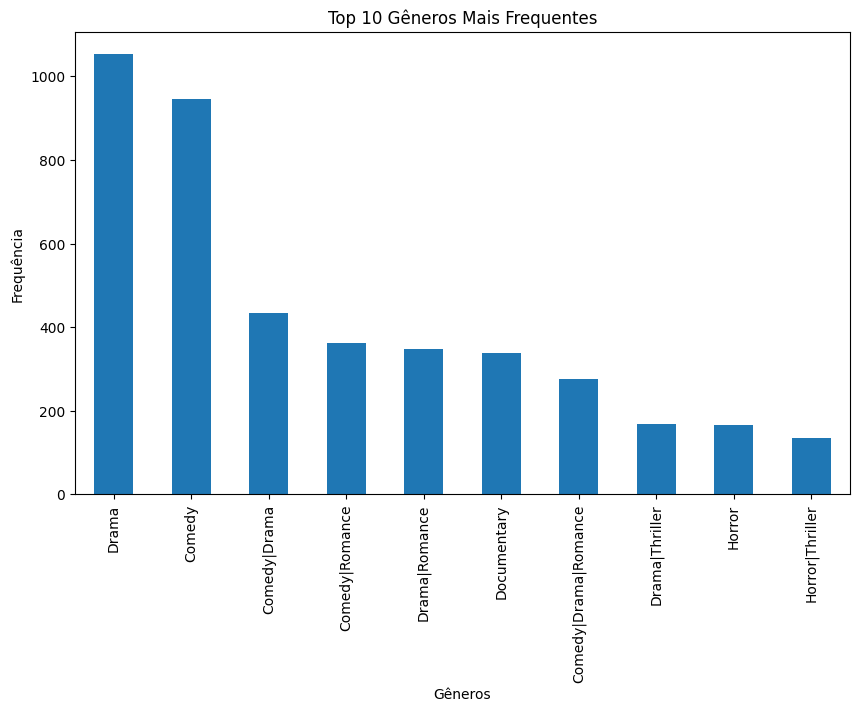

In [7]:
df_movies['genres'].value_counts().head(10).plot(kind='bar', figsize=(10, 6))
plt.title("Top 10 Gêneros Mais Frequentes")
plt.xlabel("Gêneros")
plt.ylabel("Frequência")
plt.show()


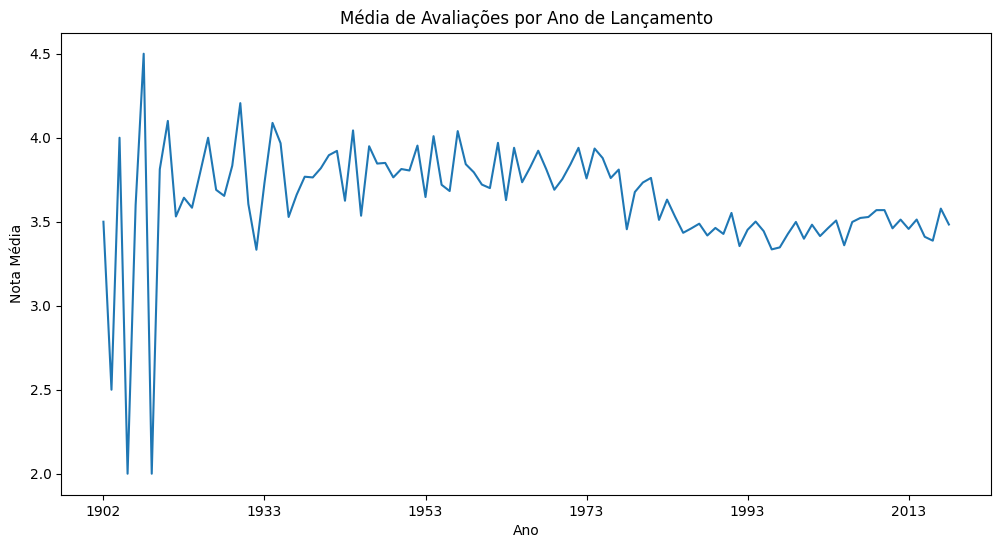

In [8]:
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
ratings_with_year = pd.merge(df_ratings, df_movies, on='movieId')
ratings_with_year.groupby('year')['rating'].mean().plot(figsize=(12, 6))
plt.title("Média de Avaliações por Ano de Lançamento")
plt.xlabel("Ano")
plt.ylabel("Nota Média")
plt.show()

In [9]:
top_movies = df_ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
top_movies.columns = ['mean_rating', 'rating_count']
top_movies = top_movies[top_movies['rating_count'] > 50].sort_values(by='mean_rating', ascending=False).head(10)

top_movies = top_movies.merge(df_movies, on='movieId')
print(top_movies[['title', 'mean_rating', 'rating_count']])


                                               title  mean_rating  \
0                   Shawshank Redemption, The (1994)     4.429022   
1                              Godfather, The (1972)     4.289062   
2                                  Fight Club (1999)     4.272936   
3                              Cool Hand Luke (1967)     4.271930   
4  Dr. Strangelove or: How I Learned to Stop Worr...     4.268041   
5                                 Rear Window (1954)     4.261905   
6                     Godfather: Part II, The (1974)     4.259690   
7                               Departed, The (2006)     4.252336   
8                                  Goodfellas (1990)     4.250000   
9                                  Casablanca (1942)     4.240000   

   rating_count  
0           317  
1           192  
2           218  
3            57  
4            97  
5            84  
6           129  
7           107  
8           126  
9           100  


#### Avaliação da análise até agora

Interessante que em nosso conjunto de dados temos muitos dados sobre Drama e Comedia e além disso estamos vendo uma média das notas dos filmes parece estar diminuindo o que surgi a pergunta: Será que os filmes estão ficando piores ou a nostagia influenciou as pessoas a avaliarem melhor em media filmes mais antigos?

In [10]:
ratings_count = df_ratings.groupby('movieId')['rating'].count().reset_index()
ratings_count.columns = ['movieId', 'rating_count']

# Juntar com os títulos dos filmes
movie_popularity = ratings_count.merge(df_movies, on='movieId')
top_movies = movie_popularity.sort_values('rating_count', ascending=False).head(10)
print("Top 10 filmes mais avaliados:")
print(top_movies[['title', 'rating_count']])

# Filmes menos avaliados
least_movies = movie_popularity.sort_values('rating_count', ascending=True).head(10)
print("\nTop 10 filmes menos avaliados:")
print(least_movies[['title', 'rating_count']])


Top 10 filmes mais avaliados:
                                          title  rating_count
314                         Forrest Gump (1994)           329
277            Shawshank Redemption, The (1994)           317
257                         Pulp Fiction (1994)           307
510            Silence of the Lambs, The (1991)           279
1938                         Matrix, The (1999)           278
224   Star Wars: Episode IV - A New Hope (1977)           251
418                        Jurassic Park (1993)           238
97                            Braveheart (1995)           237
507           Terminator 2: Judgment Day (1991)           224
461                     Schindler's List (1993)           220

Top 10 filmes menos avaliados:
                                                  title  rating_count
9723                Andrew Dice Clay: Dice Rules (1991)             1
3010                       Everlasting Piece, An (2000)             1
6653                                 Untraceab

In [11]:
user_movie_matrix = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')

similarity = cosine_similarity(user_movie_matrix.fillna(0))
print("Similaridade entre usuários:\n", similarity)


Similaridade entre usuários:
 [[1.         0.02728287 0.05972026 ... 0.29109737 0.09357193 0.14532081]
 [0.02728287 1.         0.         ... 0.04621095 0.0275654  0.10242675]
 [0.05972026 0.         1.         ... 0.02112846 0.         0.03211875]
 ...
 [0.29109737 0.04621095 0.02112846 ... 1.         0.12199271 0.32205486]
 [0.09357193 0.0275654  0.         ... 0.12199271 1.         0.05322546]
 [0.14532081 0.10242675 0.03211875 ... 0.32205486 0.05322546 1.        ]]


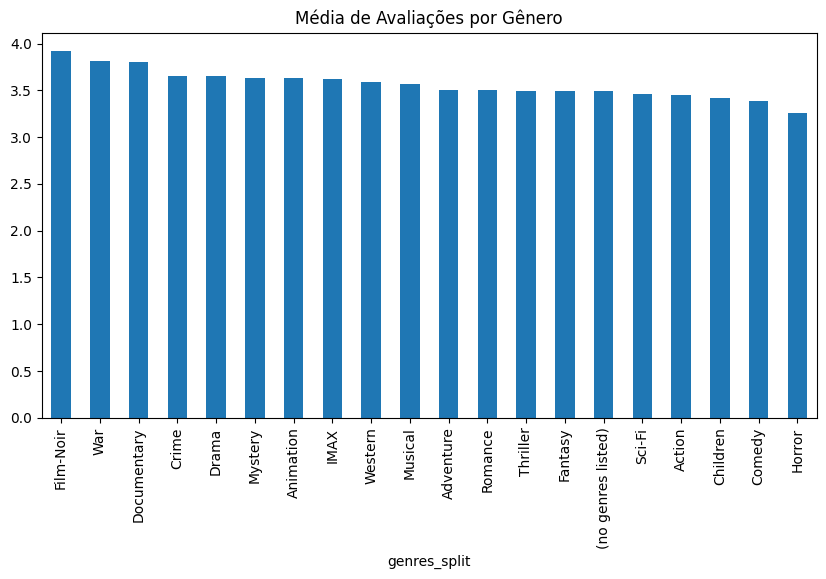

In [12]:
df_movies['genres_split'] = df_movies['genres'].str.split('|')
ratings_with_genres = df_ratings.merge(df_movies, on='movieId')
genre_ratings = ratings_with_genres.explode('genres_split').groupby('genres_split')['rating'].mean().sort_values(ascending=False)

# Visualizar
genre_ratings.plot(kind='bar', figsize=(10, 5), title='Média de Avaliações por Gênero')
plt.show()


# Primeira solução de recomendação

Podemos indicar os filmes mais populares para os clientes mais novos, assim não precisamos identificar de imediato qual o gosto do cliente e já podemos fornecer filmes que no geral ele vai gostar.

In [14]:
ratings_count = df_ratings.groupby('movieId')['rating'].count().reset_index()
ratings_count.columns = ['movieId', 'rating_count']

mean_rating = df_ratings.groupby('movieId')['rating'].mean().reset_index()
mean_rating.columns = ['movieId', 'mean_rating']

movie_popularity = pd.merge(ratings_count, mean_rating, on='movieId')

movie_popularity = pd.merge(movie_popularity, df_movies[['movieId', 'title']], on='movieId')

popular_movies = movie_popularity[movie_popularity['rating_count'] > 50]

popular_movies = popular_movies.sort_values(by='mean_rating', ascending=False)

print(popular_movies[['title', 'mean_rating', 'rating_count']].head(10))

                                                  title  mean_rating  \
277                    Shawshank Redemption, The (1994)     4.429022   
659                               Godfather, The (1972)     4.289062   
2224                                  Fight Club (1999)     4.272936   
974                               Cool Hand Luke (1967)     4.271930   
602   Dr. Strangelove or: How I Learned to Stop Worr...     4.268041   
686                                  Rear Window (1954)     4.261905   
921                      Godfather: Part II, The (1974)     4.259690   
6298                               Departed, The (2006)     4.252336   
913                                   Goodfellas (1990)     4.250000   
694                                   Casablanca (1942)     4.240000   

      rating_count  
277            317  
659            192  
2224           218  
974             57  
602             97  
686             84  
921            129  
6298           107  
913            126

# Segunda solução de recomendação

Realizar a recomendação de um filme pela similaridade do filme que foi assistido com outros filmes do catalogo.

In [17]:
def recommend_movies(movie_id, cosine_sim_df, top_n=10):
    similar_scores = cosine_sim_df[movie_id].sort_values(ascending=False)

    similar_scores = similar_scores.drop(movie_id)

    recommended_movie_ids = similar_scores.head(top_n).index
    recommended_movies = df_movies[df_movies['movieId'].isin(recommended_movie_ids)]

    return recommended_movies[['title']]

In [18]:
user_movie_matrix = df_ratings.pivot_table(index='userId', columns='movieId', values='rating')

user_movie_matrix = user_movie_matrix.fillna(0)

cosine_sim = cosine_similarity(user_movie_matrix.T)

cosine_sim_df = pd.DataFrame(cosine_sim, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)


In [26]:
recommended = recommend_movies(1, cosine_sim_df)
print(recommended)

                                                  title
224           Star Wars: Episode IV - A New Hope (1977)
314                                 Forrest Gump (1994)
322                               Lion King, The (1994)
418                                Jurassic Park (1993)
546                          Mission: Impossible (1996)
615                Independence Day (a.k.a. ID4) (1996)
911   Star Wars: Episode VI - Return of the Jedi (1983)
964                                Groundhog Day (1993)
969                           Back to the Future (1985)
2355                                 Toy Story 2 (1999)


# Terceira solução de recomendação

Envolve utilizar o SVD(Singular Value Decomposition) visa reduzir a dimensionalidade dos dados e a ideia dele é prever qual nota o usuario derá a um determinado filme.

In [30]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

svd = SVD()
svd.fit(trainset)

predictions = svd.test(testset)

rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.8812
RMSE: 0.8812169499605172


O RMSE (Root Mean Square Error) de 0.88 obtido pelo modelo SVD pode ser considerado bastante razoável para um sistema de recomendação simples. A interpretação é que o modelo, em média, erra por 0.88 pontos nas previsões das avaliações dos filmes, que variam de 1 a 5. Considerando esse intervalo, o erro médio do modelo representa cerca de 17,6% da variação total das avaliações possíveis, o que é um desempenho respeitável, especialmente para um modelo inicial.

In [37]:
id_user = 1
id_movie = 1 # Corresponde ao Toy Story

test_model = svd.predict(id_user, id_movie)
print(f'Previsão de avaliação: {round(test_model.est, 2)}')

Previsão de avaliação: 4.56


In [38]:
id_user = 50

test_model = svd.predict(id_user, id_movie)
print(f'Previsão de avaliação: {round(test_model.est, 2)}')

Previsão de avaliação: 3.32


In [39]:
id_user = 100

test_model = svd.predict(id_user, id_movie)
print(f'Previsão de avaliação: {round(test_model.est, 2)}')

Previsão de avaliação: 4.11
